In [176]:
import numpy as np
import matplotlib.pyplot as plt

In [177]:
def gaussian_data(mus, covmats, n):
    g1 = np.random.multivariate_normal(mus[0], covmats[0], int(n / 2))
    y1 = np.ones((int(n / 2), 1))
    xy1 = np.concatenate((g1, y1), axis=1)
    g2 = np.random.multivariate_normal(mus[1], covmats[1], int((n + 1) / 2))
    y2 = - np.ones((int((n + 1) / 2), 1))
    xy2 = np.concatenate((g2, y2), axis=1)
    xy = np.concatenate((xy1, xy2), axis=0)
    np.random.shuffle(xy)
    return xy                      

In [244]:
xy = gaussian_data(([1, 1], [3, 3]), (np.eye(2), np.eye(2)), 1000)
positive = xy[xy[:, 2] == 1]
negative = xy[xy[:, 2] == -1]
# plt.scatter(positive[:, 0], positive[:, 1])
# plt.scatter(negative[:, 0], negative[:, 1])
# plt.show()
xmat = xy[:, :2].T
xmean = np.mean(xmat, axis=1)
xvar = np.var(xmat, axis=1)
d = xmat.shape[0]
n = xmat.shape[1]
meanmat = np.repeat(xmean.reshape((d,1)), n, axis=1)
varmat = np.repeat(xvar.reshape((d,1)), n, axis=1)
xmat_centered = (1 / varmat) * (xmat - meanmat)

xy_cr = np.concatenate((xmat_centered, xy[:, 2:].T), axis=0)
positive = xy_cr[xy_cr[2, :] == 1]
negative = xy_cr[xy_cr[2, :] == -1]
plt.scatter(positive[0, :], positive[1, :])
plt.scatter(negative[0, :], negative[1, :])
plt.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 3 but corresponding boolean dimension is 1000

## LossFunc class
We create here an almost empty class model for losses functions. The objective is to be able to change loss function easily

In [179]:
class LossFunc:
    
    def __init__(self):
        self.primal = None
        self.dual = None
        self.sdca_update = None
        self.sgd_update = None
    
    def set_primal(self, func):
        self.primal = func
    
    def set_dual(self, func):
        self.dual = func
    
    def set_sdca_update(self, func):
        self.sdca_update = func
    
    def set_sgd_update(self, func):
        self.sgd_update = func

We define the hinge loss using the class framework defined above

In [180]:
def vector_hinge_loss(a, y):
    return np.maximum(0, 1 - y * a)

def vector_hinge_dual(alpha, y):
    prod = alpha * y
    prod[prod > 0] = np.inf
    prod[prod < -1] = np.inf
    return prod

def hinge_delta_alpha(w, xi, yi, alphai, lamb):
    n = xi.shape[0]
    q = lamb * n * (1 - np.dot(xi.T, w) * yi) / np.power(np.linalg.norm(xi), 2)
    q += alphai * yi
    return yi * max(0, min(1, q)) - alphai
    
hinge = LossFunc()
hinge.set_primal(vector_hinge_loss)
hinge.set_dual(vector_hinge_dual)
hinge.set_sdca_update(hinge_delta_alpha)

## Primal and dual of cumulative regularized loss
We define in this section:
1. Some intermediaries functions
1. The primal dual correspondance function (associating w(alpha) to alpha)
1. The primal and dual cumulative loss functions
1. The duality gap function

In [181]:
def xmatT_dot_w(xmat, w):
    return np.dot(xmat.T, w)

In [182]:
def cum_loss(w, xmat, y, lamb, lossfunc=hinge):
    a = xmatT_dot_w(xmat, w)
    cumloss = np.mean(lossfunc.primal(a, y))
    reg = (lamb / 2) * np.power(np.linalg.norm(w), 2)
    return cumloss + reg

In [183]:
def alpha_to_w(alpha, xmat, lamb):
    n = xmat.shape[1]
    return (1 / (n * lamb)) * np.dot(xmat, alpha)

In [191]:
def cum_loss_dual(alpha, xmat, y, lamb, lossfunc=hinge):
    cumlossdual = np.mean(- lossfunc.dual(- alpha, y))
    w = alpha_to_w(alpha, xmat, lamb)
    reg = (lamb / 2) * np.power(np.linalg.norm(w), 2)
    return cumlossdual + reg

In [197]:
# Test for those few first functions
w_test = np.array([1, 1])
w_test = w_test.reshape((2, 1))
a = w_dot_xmat(w_test, xmat)
h = vector_hinge_loss(a, y)
cumloss = cum_loss(w_test, xmat, y, 1)
n = xmat.shape[1]
alpha_test = 0.5 * np.ones((n,))
cum_loss_dual(alpha_test, xmat, y, 1)

-inf

In [193]:
def duality_gap(alpha, xmat, y, lamb, lossfunc=hinge):
    w = alpha_to_w(alpha, xmat, lamb)
    p = cum_loss(w, xmat, y, lamb, lossfunc)
    d = cum_loss_dual(alpha, xmat, y, lamb, lossfunc)
    return p - d

## Modified SGD for initialization

We wish to find $\alpha_t$ that maximizes : 
$$ - \phi_t^{\star}(-\alpha_t) - \frac{\lambda t}{2} ||w^{(t-1)} + (\lambda t)^{-1} \alpha_t x_t ||^2$$

Developping the previous expression yields : 
$$ \alpha_t y_t - \frac{\lambda t}{2} ( ||w^{(t-1)}||^2 + 2 \frac{\alpha_t}{\lambda t} \langle w^{(t-1)}, x_t \rangle + \frac{\alpha_t^2}{\lambda^2 t^2}||x_t||^2 )$$

This is a second order polynomial in $\alpha_t$. With a negative coefficient on the second order term. Thus this is concave. Setting the derivative w.r.t $\alpha_t$ yields : 

$$ y_t - \langle w^{(t-1)}, x_t \rangle - \frac{\alpha_t^2}{2 \lambda t} = 0$$


This gives us an optimal $\alpha_t$ which is given by : 
$$ \alpha_t= \frac{\lambda t}{||x_t||^2} (y_t - x_t^T w^{(t-1)})$$

In [194]:
def hinge_sgd_update(w, xt, yt, lamb, t):
    wdotx = np.dot(xt.T, w)
    xsqrnorm = np.power(np.linalg.norm(xt), 2)
    return ((lamb * t) / xsqrnorm) * (yt - wdotx)

hinge.set_sgd_update(hinge_sgd_update)

In [200]:
def modified_sgd(xmat, y, lamb, lossfunc=hinge):
    d = xmat.shape[0]
    n = xmat.shape[1]
    alpha = np.zeros((n, ))
    w = np.zeros((d, ))
    for t in range(0, n):
        alpha[t] = lossfunc.sgd_update(w, xmat[:, t], y[t], lamb, t)
        w = alpha_to_w(alpha[:t + 1], xmat[:, :t + 1], lamb)
    return alpha, w       

In [202]:
alpha0, w0 = modified_sgd(xmat, y, 1)
alpha0

array([  0.00000000e+00,   3.07659918e-01,   3.37305863e-01,
         9.63949288e-02,  -4.92572660e-01,   1.79747697e+00,
         8.78430465e+00,  -1.89217481e+00,   2.13093978e+01,
        -5.20062829e+00,  -1.13782729e+00,  -1.63819422e+00,
         1.44721275e+00,  -3.55013866e-01,   1.55782384e-01,
        -3.00361167e-01,  -7.84664333e-02,  -4.63756537e-01,
         1.48959721e+01,  -1.34463050e+00,   6.22217334e+01,
        -2.63715393e+00,  -4.19706979e+00,  -5.62533321e+00,
        -7.17722369e+00,   6.29145203e+00,  -1.99175571e+00,
         1.25463955e+01,  -1.21955703e+01,   1.80079279e+01,
        -9.14341533e+00,   9.71154747e+00,   1.42782358e+01,
        -9.55838167e+00,   6.73220781e-02,   4.01715353e-02,
         2.54580403e+01,   5.65843400e+01,  -7.37524060e+00,
         1.41010086e-01,   2.65394621e+02,  -1.22119561e+01,
         1.24910936e+01,  -2.88088041e+00,   4.72353859e-01,
         2.43844543e+00,   2.00500499e+02,  -2.60860590e+01,
        -1.15868541e+01,

## SDCA Perm

In [229]:
def sdca_perm(alpha0, xmat, y, lamb, nmax_epochs, epsilon, lossfunc=hinge):
    n = xmat.shape[1]
    alpha = alpha0.copy()
    w = alpha_to_w(alpha0, xmat, lamb)
    loss_track = []
    loss_track.append(cum_loss(w, xmat, y, lamb, lossfunc))
    inds = np.array(range(0, n))
    np.random.shuffle(inds)
    gap = np.inf
    k = 0
    # while (gap > epsilon) and (k < nmax_epochs) :
    while k < nmax_epochs :
        inds = np.array(range(0, n))
        np.random.shuffle(inds)
        for j in range(0, n):
            i = inds[j]
            delta = lossfunc.sdca_update(w, xmat[:, i], y[i], alpha[i], lamb)
            alpha[i] += delta
            w += (1 / (lamb * n)) * delta * xmat[:, i]
        k += 1
        loss_track.append(cum_loss(w, xmat, y, lamb, lossfunc))
        gap = duality_gap(alpha, xmat, y, lamb, lossfunc)
        print(gap)
    return w, alpha, loss_track

In [230]:
wstar, alphastar, hist = sdca_perm(alpha_test, xmat, y, 1, 100, 0.0000001)

0.933549622339
0.548021964302
0.299991130983
0.134930022655
0.0306911502543
-0.013463228513
-0.0284323627637
-0.03323489946
-0.0360408743296
-0.0374645467499
-0.0382215146665
-0.0387923883649
-0.0396329675611
-0.0402481367974
-0.0411318408076
-0.041835297626
-0.042485904804
-0.043214353001
-0.0438386443562
-0.0445147913151
-0.0451166831388
-0.0456507023831
-0.0462107508617
-0.0466293663793
-0.0470442252949
-0.0473361915673
-0.0476825198867
-0.0479166963749
-0.0481367831533
-0.0482664576094
-0.0483665737185
-0.048453417338
-0.0486131277
-0.0487865644816
-0.0489387329214
-0.0490666437797
-0.0491876164042
-0.0493218751118
-0.049499829749
-0.0496114413853
-0.0497189020388
-0.0497769147949
-0.0498119137232
-0.0498270404273
-0.0498278887892
-0.0498977864388
-0.0499695281979
-0.0500678185543
-0.050194077152
-0.050256662922
-0.0503234949168
-0.0503386466074
-0.0503647662507
-0.0503720454855
-0.0503691696469
-0.0503907604874
-0.0504201195466
-0.0504404264125
-0.0504594377834
-0.0504841060661
-0

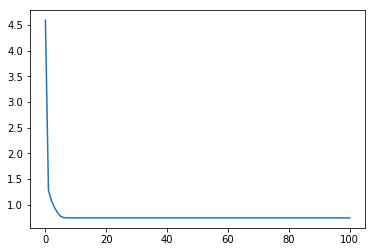

array([-0.16384303, -0.15978787])

In [231]:
plt.plot(hist)
plt.show()
wstar

In [232]:
def hyperplane(w, xgrid):
    return (-w[0] / w[1]) * xgrid

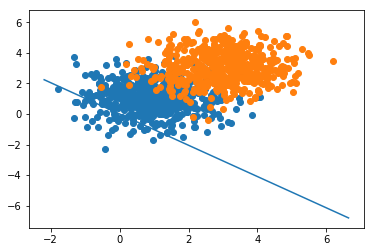

In [233]:
positive = xy[xy[:, 2] == 1]
negative = xy[xy[:, 2] == -1]
fig = plt.figure()
plt.scatter(positive[:, 0], positive[:, 1])
plt.scatter(negative[:, 0], negative[:, 1])
ax = fig.axes[0]
xlim = ax.get_xlim()
xgrid = np.linspace(xlim[0], xlim[1], 1000)
sep = (xgrid, hyperplane(wstar, xgrid))
ax.plot(sep[0], sep[1])
plt.show()